## Learning Objectives
<font color="#12A80D"> <b>
1. Prepare the environment and data</br>• Install dependencies, configure Google Colab, and mount Google Drive.</br>• Load, preprocess, and scale historical stock market data for modeling.
2. Build and train a deep learning model</br>• Implement a time-series forecasting model using TensorFlow/Keras with attention-based architecture.</br>• Apply training callbacks for performance optimization.
3. Evaluate and save results</br>• Assess model performance using standard regression metrics.</br>• Save trained models, scalers, and outputs for reuse.

</font>

# Environment Setup

## Load Dependencies into the Colab Runtime Environment
<font color="#12A80D"> <b>• Installs and upgrades required Python packages in the Colab environment.</br>• Any installation errors can be ignored, as unused dependencies do not affect the execution of <code>Nvidia_Stock_Market_History_SimpleAttention_90D_Week4.ipynb</code>.</b> </font>

In [ ]:
# =====================================
# SETUP AND INSTALL DEPENDENCIES
# =====================================
!pip install --upgrade pip
!pip install --quiet ipywidgets
!pip install --upgrade numpy==2.0.2
!pip install --quiet tensorflow==2.18.0
!pip install --quiet pandas==2.2.2 matplotlib seaborn scikit-learn==1.6.1 tqdm
!pip install --quiet transformers==4.53.1 tokenizers newsapi-python==0.2.7

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.18.0 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.18.0 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.18.0 which is incompatible.
tensorstore 0.1.76 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.4.1 which is incompatible.


## Import the Necessary Libraries and Modules
<font color="#12A80D"> <b>Enables Colab’s custom widget manager and imports libraries for file operations, numerical computation, data manipulation, visualization, preprocessing, model building, evaluation, callbacks, date handling, interactive widgets, serialization, and reproducibility.</b> </font>

In [ ]:
# Enable custom Jupyter widget support in Google Colab
from google.colab import output
output.enable_custom_widget_manager()

# Standard library imports
import os              # For file path operations and environment variables
import random          # For reproducibility (random number generation)
from datetime import datetime  # For date/time handling and logging

# Data manipulation & analysis
import numpy as np     # For numerical computations and arrays
import pandas as pd    # For data manipulation and analysis (DataFrames)

# Visualization
import matplotlib.pyplot as plt  # For plotting and visualizing data

# Machine learning preprocessing
from sklearn.preprocessing import MinMaxScaler  # For scaling features to a fixed range
from sklearn.metrics import r2_score            # For model performance evaluation (R² metric)

# TensorFlow / Keras deep learning
import tensorflow as tf                         # TensorFlow backend
from tensorflow import keras                    # High-level Keras API
from tensorflow.keras import regularizers       # Tools for applying L1, L2, or combined L1/L2 penalties to layer weights
from tensorflow.keras.layers import (           # Neural network layers
    Input,          # Input layer for defining model input shape
    Layer,          # Base layer class for custom layers
    Dense,          # Fully connected layer
    Conv1D,         # 1D convolution layer (for time-series feature extraction)
    GRU,            # Gated Recurrent Unit layer (recurrent neural net)
    Bidirectional,  # Wrapper for bidirectional RNNs
    LSTM            # Long Short-Term Memory layer
)
from tensorflow.keras.callbacks import (        # Training callbacks
    EarlyStopping,       # Stop training early if performance stops improving
    ReduceLROnPlateau    # Reduce learning rate when a metric stops improving
)

# Interactive widgets for Jupyter/Colab
from ipywidgets import interact, widgets        # For interactive controls (sliders, dropdowns)

# Serialization
import pickle                                   # Save/load Python objects (models, scalers, etc.)


## Check TensorFlow version and GPU availability
<font color="#12A80D"> <b>• Displays the installed TensorFlow version</br>• Lists available GPU devices detected by TensorFlow</br>• “If [ ] → go to Runtime → Change runtime type → set GPU.</b> </font>

In [ ]:
# GPU check
print("TensorFlow version:", tf.__version__)  # Display installed TensorFlow version
print("GPU Available:", tf.config.list_physical_devices('GPU'))  # List detected GPUs

TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Mount Google Drive in the Colab notebook to access its contents
<font color="#12A80D"> <b>• Requires granting access to Google Drive</br>• Forces remounting even if already mounted</b> </font>

In [ ]:
# Mount Google Drive in Google Colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # force_remount=True ensures a fresh mount

Mounted at /content/drive


## Define directories and collect user input for configuration
<font color="#12A80D"> <b>• Requires Google Drive to be mounted</br>• Sets base directories for dataset location and training outputs</br>• Prompts for lookback window, base output folder name, and graph name, with defaults if left blank</br>• Creates a fixed ensemble directory structure inside the training folder, organized by lookback period (e.g., <code>90D</code>)</br>• Generates a timestamped subfolder within the lookback directory to store outputs</br>• No error is raised if the directories already exist</b> </font>

In [ ]:
# =====================================
# DIRECTORIES AND USER INPUTS
# =====================================

# Base directories for dataset and training outputs
base_dir = '/content/drive/MyDrive/Nvidia_Stock_Market_History'
training_base_dir = f'{base_dir}/Training'

# Path to the dataset CSV file
dataset_path = f'{base_dir}/Data/nvidia_stock_data.csv'
print(f"Dataset: {dataset_path}")

# Collect user inputs (with defaults if Enter is pressed without typing)
lookback = int(input("Enter lookback window (e.g., 20): ") or 20)        # Number of past days for sequence input
base_name = input("Enter a base name for output folder: ") or "Nvidia_Stock_Training"
graph_base_name = input("Enter a base name for graphs: ") or "NvidiaGraph"

# Fixed ensemble directory + lookback subfolder, e.g., .../Training/ensemble_inputs/365D
ensemble_dir = os.path.join(training_base_dir, "ensemble_inputs", f"{lookback}D")
os.makedirs(ensemble_dir, exist_ok=True)

# Create a timestamped subfolder for saving outputs inside the lookback folder
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
subfolder = os.path.join(ensemble_dir, f"{base_name}_{timestamp}")
os.makedirs(subfolder, exist_ok=True)

print(f"Outputs will be saved in: {subfolder}")


Dataset: /content/drive/MyDrive/Nvidia_Stock_Market_History/nvidia_stock_data.csv
Enter lookback window (e.g., 20): 90
Enter a base name for output folder: Nvidia_Stock_Training_90D_SA
Enter a base name for graphs: Nvidia
Outputs will be saved in: /content/drive/MyDrive/Nvidia_Stock_Market_History/Training/ensemble_inputs/90D/Nvidia_Stock_Training_90D_SA_2025-08-13_03-13-06


## Set random seeds for reproducibility
<font color="#12A80D"> <b>• Ensures consistent results across runs by fixing random seeds for Python, NumPy, and TensorFlow</br>• Enables deterministic TensorFlow operations for reproducible training</b> </font>

In [ ]:
# =====================================
# Reproducibility Settings
# =====================================

# Fixed random seed value for reproducible results across runs
SEED = 42

# Ensure Python's hashing operations are deterministic by fixing the hash seed
os.environ['PYTHONHASHSEED'] = str(SEED)

# Set the seed for Python's built-in random module
random.seed(SEED)

# Set the seed for NumPy's random number generator
np.random.seed(SEED)

# Set the seed for TensorFlow's random number generator
tf.random.set_seed(SEED)

# Force TensorFlow to use deterministic operations where possible
# (may slightly slow down training but ensures reproducibility)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

## Load the dataset and perform feature engineering for time series modeling
<font color="#12A80D"> <b>• Loads NVIDIA OHLCV data from CSV, converts dates, and sorts chronologically.</br>• Creates technical indicators (moving averages, volatility, returns, Bollinger Bands, ranges, lag values, and rolling rank) to help the model capture market trends, volatility patterns, momentum, and price relationships.</br>• Drops NaN rows from rolling calculations before modeling.</b> </font>

In [ ]:
# =====================================
# LOAD AND FEATURE ENGINEER DATA
# =====================================

# Load the dataset from CSV file
df = pd.read_csv(dataset_path)

# Convert 'Date' column to datetime format for proper time-series handling
df['Date'] = pd.to_datetime(df['Date'])

# Sort data chronologically and reset the index (important for time-series models)
df = df.sort_values('Date').reset_index(drop=True)

# Feature Engineering from Jupyter Notebook

# Moving Averages: capture short-, medium-, and long-term trends
df['MA20'] = df['Close'].rolling(window=20).mean() # 20-day moving average
df['MA50'] = df['Close'].rolling(window=50).mean() # 50-day moving average
df['MA200'] = df['Close'].rolling(window=200).mean() # 200-day moving average

# Rolling Standard Deviation: measure volatility over short and medium terms
df['STD20'] = df['Close'].rolling(window=20).std() # 20-day volatility
df['STD50'] = df['Close'].rolling(window=50).std() # 50-day volatility

# Percentage Returns: short-, medium-, and long-term return changes
df['Return1'] = df['Close'].pct_change()  # 1-day return
df['Return5'] = df['Close'].pct_change(5) # 5-day return
df['Return20'] = df['Close'].pct_change(20)  # 20-day return

# Bollinger Bands: volatility-based upper and lower price bounds
df['Bollinger_Upper'] = df['MA20'] + 2 * df['STD20']
df['Bollinger_Lower'] = df['MA20'] - 2 * df['STD20']

# Daily range: difference between the high and low price of the day
df['Range'] = df['High'] - df['Low']

# Intraday change: difference between closing and opening price
df['Close_Open'] = df['Close'] - df['Open']

# Lag feature: previous day's closing price (helps capture autocorrelation)
df['Lag1'] = df['Close'].shift(1)

# Rolling percentile rank: how the latest close ranks within the last 20 days
df['Rank20'] = df['Close'].rolling(20).apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1])

# List of selected feature columns for modeling
features = [
    'Close', 'Volume', 'Open', 'High', 'Low',
    'MA20', 'MA50', 'MA200', 'STD20', 'STD50',
    'Return1', 'Return5', 'Return20',
    'Bollinger_Upper', 'Bollinger_Lower',
    'Range', 'Close_Open', 'Lag1', 'Rank20'
]

# Remove rows with NaN values (caused by rolling/shift operations) and reset index
df = df.dropna().reset_index(drop=True)

# Print summary of features used and final dataset shape
print("Columns used as features:", features)
print("Data shape after dropping NaNs:", df.shape)


Columns used as features: ['Close', 'Volume', 'Open', 'High', 'Low', 'MA20', 'MA50', 'MA200', 'STD20', 'STD50', 'Return1', 'Return5', 'Return20', 'Bollinger_Upper', 'Bollinger_Lower', 'Range', 'Close_Open', 'Lag1', 'Rank20']
Data shape after dropping NaNs: (6479, 20)


## Scale feature columns using Min-Max normalization
<font color="#12A80D"> <b>• Scales each feature to the [0, 1] range using `MinMaxScaler`.</br>• Stores a separate scaler for each column for later inverse transformations.</b> </font>

In [ ]:
# =====================================
# Feature Scaling
# =====================================

# Dictionary to store the fitted scaler for each feature (for inverse transforms later)
scalers = {}

# List to temporarily hold the scaled arrays for each feature
scaled_columns = []

# Loop through each feature column and scale individually
for col in features:
    scaler = MinMaxScaler() # Initialize Min-Max Scaler (scales data to [0, 1])
    scaled = scaler.fit_transform(df[[col]])  # Fit on the column and transform it
    scalers[col] = scaler # Save scaler for this column
    scaled_columns.append(scaled) # Append scaled column to list

# Combine all scaled columns horizontally into one NumPy array
# Result: rows = samples, columns = features, all values scaled to [0, 1]
scaled_data = np.hstack(scaled_columns)

## Create input-output sequences for time series modeling
<font color="#12A80D"> <b>• Generates sequences of length `lookback` as model inputs (`X`) and the next time step’s target value (`y`).</br>• Uses the first feature column as the prediction target.</b> </font>

In [ ]:
# =====================================
# Create sequences for time-series modeling
# =====================================

# X will hold the input sequences, y will hold the target values
X, y = [], []

# Loop through the dataset starting from 'lookback' index
# This ensures each sequence contains exactly 'lookback' timesteps of data
for i in range(lookback, len(scaled_data)):
  # Append the past 'lookback' rows (all features) as one training example
    X.append(scaled_data[i-lookback:i])

    # Append the target value: the 'Close' price at the current time step
    # Assumes the first column (index 0) in scaled_data corresponds to 'Close'
    y.append(scaled_data[i, 0])

# Convert lists to NumPy arrays for model input
# Shape of X: (num_samples, lookback, num_features)
# Shape of y: (num_samples,)
X, y = np.array(X), np.array(y)

## Split the dataset into training, validation, and test sets
<font color="#12A80D"> <b>Uses 70% of the sequences for training, 20% for validation, and 10% for testing based on index ranges.</b> </font>

In [ ]:
# =====================================
# Split dataset into train, validation, and test sets
# =====================================

# Calculate split indices
split_1 = int(0.7 * len(X)) # First 70% for training
split_2 = int(0.9 * len(X))  # Next 20% for validation, final 10% for testing

# Training set: model learns patterns from this subset
X_train, y_train = X[:split_1], y[:split_1]

# Validation set: used to tune hyperparameters and monitor overfitting
X_val, y_val = X[split_1:split_2], y[split_1:split_2]

# Test set: completely unseen data for final performance evaluation
X_test, y_test = X[split_2:], y[split_2:]

## Type hint for training data array
<font color="#12A80D"> <b>• Specifies that <code>X_train</code> is expected to be a NumPy array</br>• Uses <code># type: ignore</code> to bypass static type checking errors if variable definition occurs later</b> </font>

In [ ]:
X_train: np.ndarray  # type: ignore  # Type hint says X_train should be a NumPy array; ignore type-checking errors for this line

## Define a custom SimpleAttention layer for sequence weighting
<font color="#12A80D"> <b>• Implements additive attention over time steps</br>• Expects input shaped <code>(batch, timesteps, features)</code></br>• Computes scores via <code>tanh(W1(x))</code> then a scalar projection and <code>softmax</code> along the time axis</br>• Outputs a single context vector per sample by weighted summation across time</br>• <code>units</code> sets the attention hidden size</br>• No masking or weight return by default</br>• Place after RNN/CNN layers to summarize sequence information for downstream dense layers</b> </font>

In [ ]:
# =====================================
# CUSTOM Simple ATTENTION LAYER
# =====================================

class SimpleAttention(Layer):
    def __init__(self, units):
        super(SimpleAttention, self).__init__()
        self.W1 = Dense(units)  # Dense layer to learn intermediate attention scores
        self.V = Dense(1)       # Dense layer to project scores to a single value per timestep

    def call(self, hidden_states):
        # Apply a non-linear transformation to the hidden states
        score = tf.nn.tanh(self.W1(hidden_states))

        # Convert scores to probabilities (attention weights) along the time axis
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # Weight the hidden states by their attention scores
        context_vector = attention_weights * hidden_states

        # Sum across the time dimension to get a single context vector per sample
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector

## Build the sequence model with CNN, Bi-GRU stacks, and SimpleAttention
<font color="#12A80D"> <b>• Defines a Sequential model designed to process sequences with a 90-day lookback window for NVIDIA stock forecasting</br>• Extracts local temporal patterns using <code>Conv1D</code>, models long-range dependencies with stacked Bidirectional GRUs, applies <code>SimpleAttention</code> to focus on the most relevant time steps, and outputs a single regression value</b>
</br>Layer-by-layer breakdown:
</br>• <b><code>Conv1D(64, kernel_size=3, activation="relu")</code></b> — 1-D convolutional layer with 64 filters; each filter scans over a sliding window of 3 timesteps to detect short-term temporal patterns in the input sequence. The <code>relu</code> activation introduces non-linearity and helps model complex patterns. The input shape <code>(timesteps=90, features)</code> matches the 90-day lookback period.
</br>• <b><code>Bidirectional(GRU(250, return_sequences=True, dropout=0.2))</code></b> — Gated Recurrent Unit (GRU) layer with 250 units. Bidirectional processing allows the model to learn from both past and future context within the lookback window. <code>return_sequences=True</code> ensures each timestep’s output is passed to the next layer, and <code>dropout=0.2</code> reduces overfitting. Two such layers are stacked to progressively learn higher-level temporal dependencies. <code>kernel_regularizer=regularizers.l2(1e-5)</code> is used with the last BIGRU to add weight regularization to layers (e.g., Dense, Conv1D, GRU) to help reduce overfitting.
</br>• <b><code>SimpleAttention(units=128)</code></b> — Custom attention mechanism with 128 hidden units in its scoring network. Learns to assign weights to timesteps, focusing on the most relevant portions of the 90-day history for prediction.
</br>• <b><code>Dense(1)</code></b> — Fully connected layer producing a single output value (predicted closing price or target variable).

</br>Why this configuration for 90-day lookback:
</br>• The <b>Conv1D</b> layer quickly captures local fluctuations (e.g., weekly or monthly patterns) before recurrent processing.
</br>• Stacked <b>Bidirectional GRUs</b> efficiently model complex, long-term dependencies in a full-year sequence without the higher memory cost of LSTMs.
</br>• The <b>Attention layer</b> compensates for the long sequence length by allowing the model to focus on important days rather than treating all 90 equally.
</br>• The combination of convolution, recurrent memory, and attention balances short-term volatility detection with long-term trend analysis, which is critical for annual lookback forecasting.
</font>
</br></br>
<font color="#12A80D">
  <b><big>Additional explanation:</big></b>
  <br>• <b><code>model.compile(optimizer="adam", loss="mse", metrics=["mae", "mse"])</code></b> — Configures the model for training. Uses the Adam optimizer for adaptive learning rate adjustment, Mean Squared Error (MSE) as the loss function for regression, and tracks both Mean Absolute Error (MAE) and MSE as evaluation metrics during training.
  <br>• <b><code>model.summary()</code></b> — Prints a detailed architecture table including each layer’s name, type, output shape, and number of trainable parameters, as well as the total parameter count. This helps verify that layer dimensions match expectations and that all intended components are present before training.
</font>



In [ ]:
# =====================================
# BUILD MODEL
# =====================================

model = keras.Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),  # Define input shape: (timesteps, features)

    Conv1D(64, kernel_size=3, activation="relu"),       # 1D convolution to extract short-term patterns

    Bidirectional(GRU(250, return_sequences=True, dropout=0.2)),  # 1st BiGRU layer
    Bidirectional(GRU(250, return_sequences=True, dropout=0.2, kernel_regularizer=regularizers.l2(1e-5))),  # 2nd BiGRU layer

    SimpleAttention(units=128),  # Custom attention layer to focus on important timesteps

    Dense(1)  # Output layer for regression (predicting a single value)
])

# Compile model with Adam optimizer and MSE loss, tracking MAE and MSE as metrics
model.compile(optimizer="adam", loss="mse", metrics=["mae", "mse"])

# Display the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 88, 64)         │         3,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 88, 500)        │       474,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 88, 500)        │     1,128,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_attention                │ (None, 500)            │        64,257 │
│ (SimpleAttention)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,670,470 (6.37 MB)

 Trainable params: 1,670,470 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

## Model summary output for the built Sequential model
<font color="#12A80D"> <b>• Lists each layer with its type, output shape, and number of trainable parameters</br>• Shows the architecture: Conv1D → two Bidirectional GRUs → SimpleAttention → Dense output with L2 regulariation in the last BIGRU layer, allowing for weight regularization and to help reduce over fitting.</br>• Indicates how sequence dimensions evolve across layers (e.g., 90 → 88 timesteps after Conv1D with kernel size 3)</br>• Reports total parameters (1,670,470), all trainable, confirming model capacity and component inclusion</b> </font>

## Build a model configuration string for filenames
<font color="#12A80D"> <b>• Generates a compact text representation of the model architecture for use in file naming</br>• Iterates through model layers and encodes each by type and key parameters</br>• <code>C1D{filters}</code> for Conv1D layers, <code>BiG{units}</code> for Bidirectional GRUs, <code>BiL{units}</code> for Bidirectional LSTMs, <code>D{units}</code> for Dense layers, and <code>BAtt</code> for the SimpleAttention layer</br>• Joins these codes into a single string, appends the lookback window length, and prints the result</b> </font>

In [ ]:
# ---------------------------
# Build model config string
# ---------------------------

layer_descriptions = []  # Will hold short codes describing each layer

# Loop through each layer in the model
for i, layer in enumerate(model.layers):
    if isinstance(layer, Conv1D):
        # C1D followed by number of filters
        layer_descriptions.append(f"C1D{layer.filters}")

    elif isinstance(layer, Bidirectional):
        # Access the wrapped forward layer to determine type and units
        forward = layer.forward_layer
        if isinstance(forward, GRU):
            layer_descriptions.append(f"BiG{forward.units}")  # BiG = Bidirectional GRU
        elif isinstance(forward, LSTM):
            layer_descriptions.append(f"BiL{forward.units}")  # BiL = Bidirectional LSTM

    elif isinstance(layer, Dense):
        # D followed by number of units
        layer_descriptions.append(f"D{layer.units}")

    elif isinstance(layer, SimpleAttention):
        # Custom attention layer
        layer_descriptions.append("BAtt")  # BAtt = Basic (Simple) Attention

# Combine the layer codes into a single string
model_config_str = "_".join(layer_descriptions)

# Append the lookback window size to the config string
config_suffix = f"{model_config_str}_Lookback{lookback}"

# Print final configuration string for use in file naming
print("Model configuration string for filenames:", config_suffix)

Model configuration string for filenames: C1D64_BiG250_BiG250_BAtt_D1_Lookback90


## Train the model with early stopping and learning rate reduction
<font color="#12A80D"> <b>• Trains the sequence model on the training data and evaluates on the validation set each epoch</br>• Uses <code>EarlyStopping</code> to halt training if validation loss does not improve for 8 epochs, restoring the best weights</br>• Uses <code>ReduceLROnPlateau</code> to halve the learning rate if validation loss stagnates for 3 epochs, helping escape plateaus</br>• Runs for up to 200 epochs with a batch size of 32, but may stop early due to callbacks</b> </font>

In [ ]:
# =====================================
# TRAIN MODEL
# =====================================

# Early stopping callback: stops training if validation loss doesn't improve
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',        # Metric to monitor
    patience=8,                # Stop if no improvement for 8 epochs
    restore_best_weights=True, # Revert to the best model weights
    verbose=1
)

# Reduce learning rate callback: lowers LR when validation loss plateaus
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.5,          # Reduce LR by half
    patience=3,          # Wait 3 epochs without improvement before reducing
    verbose=1
)

# Train the model with training data and validate on the validation set
history = model.fit(
    X_train, y_train,                # Training inputs and targets
    epochs=200,                      # Maximum number of training epochs
    batch_size=32,                    # Number of samples per gradient update
    validation_data=(X_val, y_val),   # Validation inputs and targets
    callbacks=[early_stop, reduce_lr],# Callbacks to control training
    verbose=1                         # Display training progress
)

Epoch 1/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 0.0348 - mae: 0.0818 - mse: 0.0259 - val_loss: 0.0091 - val_mae: 0.0580 - val_mse: 0.0048 - learning_rate: 0.0010
Epoch 2/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0041 - mae: 0.0053 - mse: 4.7557e-05 - val_loss: 0.0077 - val_mae: 0.0537 - val_mse: 0.0041 - learning_rate: 0.0010
Epoch 3/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0036 - mae: 0.0046 - mse: 3.6920e-05 - val_loss: 0.0064 - val_mae: 0.0468 - val_mse: 0.0031 - learning_rate: 0.0010
Epoch 4/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0032 - mae: 0.0042 - mse: 2.9958e-05 - val_loss: 0.0041 - val_mae: 0.0272 - val_mse: 0.0011 - learning_rate: 0.0010
Epoch 5/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0029 - mae: 0.0036 - mse: 2.1635e-05 - val_loss: 0.0030 - val_mae: 0.0113 - val_mse: 2.6067e-04 - learning_rate: 0.0010
Epoch 6/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0027 - mae: 0.0031 - mse: 1.5867e-0

## Generate predictions, evaluate performance, and visualize results
<font color="#12A80D"> <b>• Constructs a full feature sequence set using the defined lookback period for every point in the dataset</br>• Feeds sequences to the trained model to obtain scaled predictions, then inversely transforms them to original price values using the <code>Close</code> scaler</br>• Computes the coefficient of determination (R²) between actual and predicted closing prices</br>• Plots actual vs. predicted closing prices over time to assess model tracking of trends</br>• Plots training and validation loss across epochs to visualize convergence and potential overfitting</b> </font>

200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
R2 Score: 0.9706


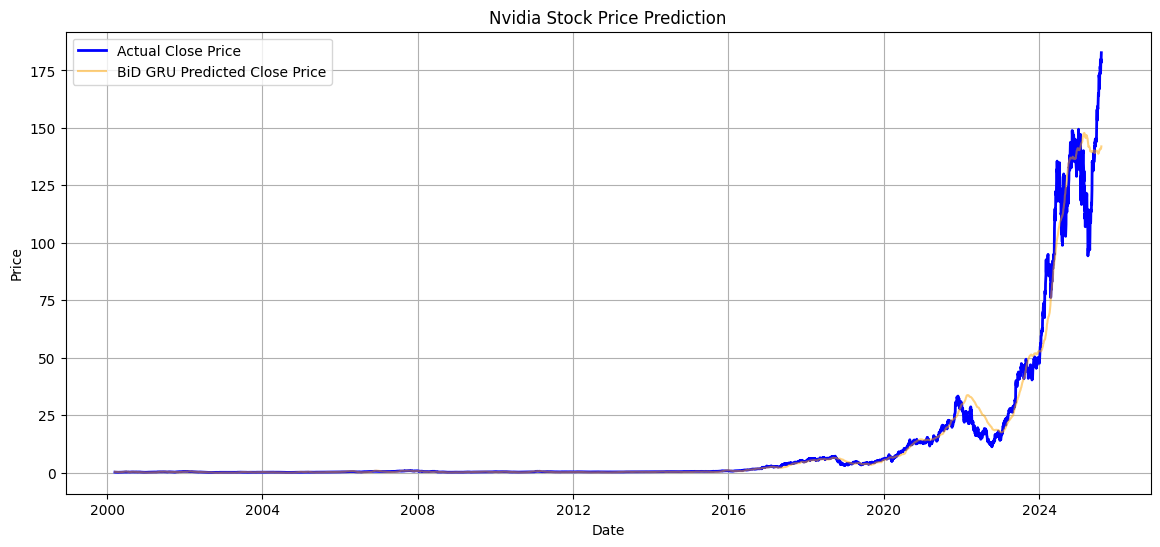

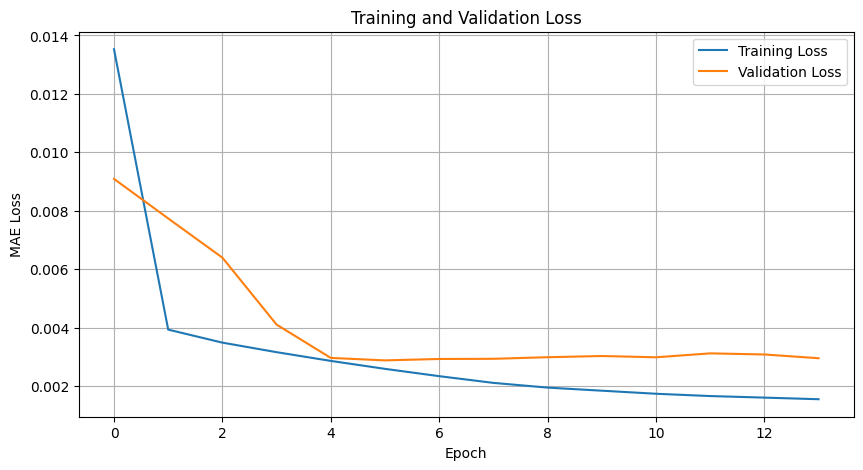

In [ ]:
# =====================================
# PREDICTIONS AND RESULTS
# =====================================

# Prepare input sequences for prediction using the full dataset
all_X = []
for i in range(lookback, len(scaled_data)):
    all_X.append(scaled_data[i - lookback:i])
all_X = np.array(all_X)

# Generate predictions (scaled)
predictions_scaled = model.predict(all_X)

# Inverse transform to get predictions back to original price scale
predictions_inverse = scalers['Close'].inverse_transform(predictions_scaled)

# Extract actual closing prices (aligned with predictions)
actual_close = np.array(df['Close'].iloc[lookback:])
dates = df['Date'].values[lookback:]

# Calculate R² score for model performance
r2 = r2_score(actual_close, predictions_inverse.flatten())
print(f"R2 Score: {r2:.4f}")

# Ensure dates array matches prediction range
dates = df['Date'].to_numpy()[lookback:]

# Plot actual vs predicted closing prices
plt.figure(figsize=(14, 6))
plt.plot(dates, actual_close, label='Actual Close Price', color='blue', linewidth=2)
plt.plot(dates, predictions_inverse, label='BiD GRU Predicted Close Price', color='orange', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Nvidia Stock Price Prediction')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## Prompt to save predictions, graphs, and model weights
<font color="#12A80D"> <b>• Asks whether to save model outputs including predictions, plots, and weights</br>• If confirmed, saves a CSV of actual vs. predicted prices, a PNG prediction plot, and a PNG training/validation loss plot in the timestamped subfolder</br>• Optionally prompts to save the model weights in H5 format</br>• Organizes all results in the configured project directory for future reference</b> </font>

In [ ]:
# =====================================
# ASK TO SAVE RESULTS
# =====================================

# Prompt user to confirm saving predictions, plots, and weights
save_choice = input("Do you want to save predictions, graphs, and weights? (yes/no): ").strip().lower()

if save_choice == 'yes':
    # Create DataFrame with dates, actual prices, and predicted prices
    output_df = pd.DataFrame({
        'Date': dates,
        'Actual_Close': actual_close,
        'Predicted_Close': predictions_inverse.flatten()
    })

    # Save predictions to CSV
    csv_path = os.path.join(subfolder, f"{graph_base_name}_{config_suffix}_predictions.csv")
    output_df.to_csv(csv_path, index=False)

    # Save prediction plot
    plt.figure(figsize=(14, 6))
    plt.plot(dates, actual_close, label='Actual Close Price')
    plt.plot(dates, predictions_inverse, label='BiD GRU Predicted Close Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Nvidia Stock Price Prediction')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    pred_plot_path = os.path.join(subfolder, f"{graph_base_name}_{config_suffix}_prediction.png")
    plt.savefig(pred_plot_path)
    plt.close()

    # Save loss plot
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MAE Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    loss_plot_path = os.path.join(subfolder, f"{graph_base_name}_{config_suffix}_loss.png")
    plt.savefig(loss_plot_path)
    plt.close()

    # Ask user if they want to save model weights
    save_weights_choice = input("Do you want to save the model weights now? (yes/no): ").strip().lower()
    if save_weights_choice == 'yes':
        weights_path = os.path.join(subfolder, f"{graph_base_name}_{config_suffix}.weights.h5")
        model.save_weights(weights_path)
        print(f"Weights saved to: {weights_path}")

    print(f"Outputs saved in: {subfolder}")

Do you want to save predictions, graphs, and weights? (yes/no): yes
Do you want to save the model weights now? (yes/no): yes
Weights saved to: /content/drive/MyDrive/Nvidia_Stock_Market_History/Training/ensemble_inputs/90D/Nvidia_Stock_Training_90D_SA_2025-08-13_03-13-06/Nvidia_C1D64_BiG250_BiG250_BAtt_D1_Lookback90.weights.h5
Outputs saved in: /content/drive/MyDrive/Nvidia_Stock_Market_History/Training/ensemble_inputs/90D/Nvidia_Stock_Training_90D_SA_2025-08-13_03-13-06
